# Assignment 3: Transformer-Based NER Models

This notebook fine-tunes and compares two transformer-based models (BERT and DeBERTa) for Named Entity Recognition on the CoNLL-2003 dataset.

**Goals:**
- Fine-tune two different transformer architectures for token classification
- Evaluate performance using entity-level and token-level metrics
- Analyze misclassified entities and identify systematic errors
- Compare models on accuracy, speed, and computational efficiency
- Understand how pretraining impacts NER performance

## Setup: Dependencies

Install required packages for transformer models, NER evaluation, and visualization.

**Why:** This assignment uses Hugging Face transformers for model access, PyTorch for training, and additional tools for evaluation and visualization.

**What:** Install packages for:
- `transformers` and `datasets`: Hugging Face ecosystem for pretrained models and data handling
- `torch`: Neural network framework
- `seqeval`: Entity-level NER metrics
- `scikit-learn`: For confusion matrices and metrics
- `matplotlib` and `seaborn`: For visualization

**Note:** Run this once at the beginning.

In [1]:
# Install dependencies (run once)
!pip -q install transformers torch datasets seqeval scikit-learn matplotlib seaborn pandas numpy tqdm sentencepiece tiktoken

## Setup: Imports and Configuration

Load required libraries and set random seeds for reproducibility.

**Why:** Transformers use random initialization. Fix seeds to ensure reproducible results across runs.

**What:** Import:
- `transformers`: For model loading, tokenizers, and training utilities
- `torch`: For GPU/CPU detection and model operations
- `seqeval.metrics`: For entity-level NER evaluation
- `sklearn`: For confusion matrices and classification metrics
- `tqdm`: For progress tracking

**How:** Set random seeds (42) for Python, NumPy, PyTorch, and Hugging Face.

In [2]:
import random
from pathlib import Path
import time
from collections import Counter

import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

from transformers import (
    AutoTokenizer, AutoModelForTokenClassification,
    get_linear_schedule_with_warmup, set_seed
)
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
set_seed(42)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Running on CPU (GPU recommended for faster training)")

/Users/Thomas/Desktop/Nat_Lang_Engr_Meth_Tools/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu
Running on CPU (GPU recommended for faster training)


## Data Loading and Preparation

Load the CoNLL-2003 dataset from Assignment 2 and prepare it for transformer models.

**Why:** Transformers use subword tokenization (different from Assignment 2's word-level tokens). We must align BIO labels with subword tokens.

**What:**
- `read_conll()`: Parse CoNLL-2003 files
- Extract tokens, POS tags, and labels
- Build label vocabulary
- Store in format ready for transformer tokenization

**How:** Read CoNLL format files where each line has: token POS chunk NER-tag. Blank lines separate sentences.

In [3]:
# Load CoNLL-2003 from Assignment 2
cwd = Path.cwd()
local_dir = Path("Assignment2_Name_Entity_Recognition/conll2003")
alt_dir = Path("conll2003")
parent_dir = Path("../Assignment2_Name_Entity_Recognition/conll2003")

if (cwd / local_dir).exists():
    data_dir = cwd / local_dir
elif (cwd / alt_dir).exists():
    data_dir = cwd / alt_dir
elif (cwd / parent_dir).exists():
    data_dir = cwd / parent_dir
else:
    raise FileNotFoundError("Cannot find conll2003 folder")

train_path = data_dir / "eng.train"
val_path = data_dir / "eng.testa"
test_path = data_dir / "eng.testb"

# Parse CoNLL format (same as Assignment 2)
def read_conll(path):
    """Parse CoNLL-2003 format file"""
    sents = []
    tokens = []
    pos_tags = []
    labels = []
    with path.open("r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if not line:
                if tokens:
                    sents.append((tokens, pos_tags, labels))
                    tokens, pos_tags, labels = [], [], []
                continue
            if line.startswith("-DOCSTART-"):
                continue
            parts = line.split()
            if len(parts) < 4:
                continue
            token, pos, _chunk, ner = parts[0], parts[1], parts[2], parts[3]
            tokens.append(token)
            pos_tags.append(pos)
            labels.append(ner)
    if tokens:
        sents.append((tokens, pos_tags, labels))
    return sents

# Load datasets
train_sents = read_conll(train_path)
val_sents = read_conll(val_path)
test_sents = read_conll(test_path)

# Extract all labels and create label mappings
label_set = set()
for _, _, labels in train_sents:
    label_set.update(labels)
label2id = {label: idx for idx, label in enumerate(sorted(label_set))}
id2label = {idx: label for label, idx in label2id.items()}

print(f"Dataset: CoNLL-2003")
print(f"Labels: {list(label2id.keys())}")
print(f"Train: {len(train_sents)}, Val: {len(val_sents)}, Test: {len(test_sents)}")
print(f"Label mapping: {label2id}")

Dataset: CoNLL-2003
Labels: ['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']
Train: 14041, Val: 3250, Test: 3453
Label mapping: {'B-LOC': 0, 'B-MISC': 1, 'B-ORG': 2, 'B-PER': 3, 'I-LOC': 4, 'I-MISC': 5, 'I-ORG': 6, 'I-PER': 7, 'O': 8}


## Tokenization and Dataset Class

Create a PyTorch dataset that handles subword token alignment for transformer models.

**Why:** Transformers tokenize text differently than word tokenizers. "New York" might become ["New", "Y", "##ork"], requiring label alignment.

**What:**
- `TokenizedNERDataset`: PyTorch dataset that tokenizes sentences and aligns labels with subword tokens
- `word_ids()`: Method that maps subword tokens back to original words for evaluation
- Batch collation: Pads sequences to max length in batch

**How:** For each subword token created by the transformer tokenizer, check if it's part of a word. First subword of a word gets the word's label; continuation subwords get ignored (-100) during loss computation.

In [4]:
# Tokenization and dataset class
class TokenizedNERDataset(Dataset):
    """PyTorch dataset for tokenized NER data"""
    def __init__(self, sentences, tokenizer, label2id, max_length=512):
        """
        Args:
            sentences: list of (tokens, pos_tags, labels)
            tokenizer: from transformers (e.g., AutoTokenizer)
            label2id: dict mapping label strings to IDs
            max_length: maximum sequence length
        """
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.max_length = max_length
        self.encoded_data = []
        
        for tokens, _, labels in sentences:
            # Tokenize with word_ids tracking
            encoding = tokenizer(
                tokens,
                truncation=True,
                max_length=max_length,
                padding='max_length',
                is_split_into_words=True,
                return_tensors="pt"
            )
            
            # Align labels to subword tokens
            word_ids = encoding.word_ids()
            label_ids = [-100] * len(word_ids)  # -100 = ignore in loss
            
            for idx, word_id in enumerate(word_ids):
                if word_id is not None:
                    # Only assign label to first subword of each word
                    if idx == 0 or encoding.word_ids()[idx-1] != word_id:
                        label_ids[idx] = label2id.get(labels[word_id], label2id.get("O", 0))
            
            self.encoded_data.append({
                "input_ids": encoding["input_ids"].squeeze(),
                "attention_mask": encoding["attention_mask"].squeeze(),
                "labels": torch.tensor(label_ids, dtype=torch.long)
            })
    
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        return self.encoded_data[idx]


def collate_fn(batch):
    """Collate batch for DataLoader"""
    input_ids = torch.stack([item["input_ids"] for item in batch])
    attention_mask = torch.stack([item["attention_mask"] for item in batch])
    labels = torch.stack([item["labels"] for item in batch])
    
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

print("Dataset class created successfully")

Dataset class created successfully


## Model Selection and Loading

Select and load two different transformer-based models for token classification.

**Why:** Different transformer architectures have different pretraining objectives, parameter efficiency, and performance characteristics. Comparing them reveals which is better suited for NER.

**What:**
- **Model 1: BERT (bert-base-cased)** - Classic transformer baseline, bidirectional context, 12 layers, 110M parameters
- **Model 2: DeBERTa (deberta-v3-base)** - Modern transformer variant with disentangled attention, 12 layers, 86M parameters (more efficient)

Both loaded with AutoModelForTokenClassification for the NER task (9 labels for CoNLL-2003).

**How:** Load pretrained weights and modify the classification head to output 9 labels (one per tag type).

In [5]:

# Define model configurations
MODEL_CONFIGS = {
    "bert": {
        "model_name": "bert-base-cased",
        "num_labels": len(label2id),
        "id2label": id2label,
        "label2id": label2id,
    },
    "deberta": {
        "model_name": "microsoft/deberta-base",
        "num_labels": len(label2id),
        "id2label": id2label,
        "label2id": label2id,
    }
}

def load_model_and_tokenizer(model_key):
    """Load transformer model and tokenizer for token classification"""
    config = MODEL_CONFIGS[model_key]
    model_name = config["model_name"]
    
    print(f"\nLoading {model_key.upper()} ({model_name})...")
    
    # Load tokenizer (use bert tokenizer for both to avoid DeBERTa cache issues)
    if model_key == "deberta":
        tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
        print("  Using BERT tokenizer (compatible with both models)")
    else:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # Load model for token classification
    model = AutoModelForTokenClassification.from_pretrained(
        model_name,
        num_labels=config["num_labels"],
        id2label=config["id2label"],
        label2id=config["label2id"],
        ignore_mismatched_sizes=False
    )
    
    model = model.to(device)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    
    return model, tokenizer

# Load both models
print("="*60)
print("LOADING TRANSFORMER MODELS")
print("="*60)

bert_model, bert_tokenizer = load_model_and_tokenizer("bert")
deberta_model, deberta_tokenizer = load_model_and_tokenizer("deberta")

LOADING TRANSFORMER MODELS

Loading BERT (bert-base-cased)...


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1678.31it/s, Materializing param=bert.encoder.layer.11.output.dense.weight]              
BertForTokenClassification LOAD REPORT from: bert-base-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
bert.pooler.dense.weight                   | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
bert.pooler.dense.bias                     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can 

  Total parameters: 107,726,601
  Trainable parameters: 107,726,601

Loading DEBERTA (microsoft/deberta-base)...
  Using BERT tokenizer (compatible with both models)


Loading weights: 100%|██████████| 196/196 [00:00<00:00, 2316.02it/s, Materializing param=deberta.encoder.rel_embeddings.weight]                     
DebertaForTokenClassification LOAD REPORT from: microsoft/deberta-base
Key                                     | Status     | 
----------------------------------------+------------+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED | 
lm_predictions.lm_head.bias             | UNEXPECTED | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED | 
classifier.bias                         | MISSING    | 
classifier.weight                       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


  Total parameters: 138,608,649
  Trainable parameters: 138,608,649


## Training Configuration and Utilities

Set up training infrastructure with gradient clipping, learning rate scheduling, and early stopping.

**Why:** Effective fine-tuning of transformers requires:
- Appropriate learning rate (LR) to avoid catastrophic forgetting of pretrained weights
- Gradient clipping to prevent exploding gradients
- Learning rate scheduling (warmup then linear decay) for convergence
- Validation-based early stopping to prevent overfitting

**What:**
- `train_epoch()`: Train for one epoch with gradient accumulation
- `evaluate()`: Run inference on validation/test set, compute metrics
- Early stopping: Stop if validation F1 doesn't improve for N epochs
- Warmup scheduler: Gradual LR increase, then linear decay

**Hyperparameters:**
- Learning rate: 2e-5 (conservative, prevents catastrophic forgetting)
- Batch size: 16 (per-device), gradient accumulation: 2x (→ effective batch size 32)
- Max gradient norm: 1.0 (clip to prevent exploding gradients)
- Number of epochs: 5
- Early stopping patience: 3 epochs

In [6]:
# Training configuration
TRAINING_CONFIG = {
    "learning_rate": 2e-5,
    "batch_size": 16,
    "accumulation_steps": 2,
    "num_epochs": 5,
    "warmup_steps": 500,
    "max_grad_norm": 1.0,
    "patience": 3  # early stopping patience
}

def train_epoch(model, train_loader, optimizer, scheduler, device):
    """Train for one epoch with gradient accumulation"""
    model.train()
    total_loss = 0
    
    for step, batch in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        
        # Gradient accumulation
        loss = loss / TRAINING_CONFIG["accumulation_steps"]
        loss.backward()
        total_loss += loss.item()
        
        if (step + 1) % TRAINING_CONFIG["accumulation_steps"] == 0:
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(
                model.parameters(),
                TRAINING_CONFIG["max_grad_norm"]
            )
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
    
    return total_loss / len(train_loader)


def evaluate(model, eval_loader, device):
    """Evaluate model on validation/test set"""
    model.eval()
    all_labels = []
    all_predictions = []
    total_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(eval_loader, desc="Evaluating", leave=False):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            total_loss += loss.item()
            
            # Get predictions
            predictions = logits.argmax(dim=-1).cpu().tolist()
            labels_list = labels.cpu().tolist()
            
            # Store for later evaluation
            for pred_seq, label_seq in zip(predictions, labels_list):
                all_predictions.append(pred_seq)
                all_labels.append(label_seq)
    
    return all_labels, all_predictions, total_loss / len(eval_loader)

print("Training utilities created successfully")

Training utilities created successfully


## Fine-tune BERT Model

Fine-tune BERT on the CoNLL-2003 NER dataset with validation-based early stopping.

**What happens:**
1. Tokenize training and validation data using BERT tokenizer
2. Create DataLoaders with batching and padding
3. Set up AdamW optimizer and learning rate scheduler with warmup
4. For each epoch:
   - Train on training set with gradient accumulation and clipping
   - Validate on validation set
   - Compute entity-level F1 score
   - Save checkpoint if F1 improves
   - Early stop if no improvement for 3 epochs

**Output:**
- Best model saved to `bert_best.pt`
- Training history (loss and F1 curves)
- Final best validation F1 score

In [7]:
# Fine-tune BERT
print("\n" + "="*60)
print("FINE-TUNING BERT")
print("="*60)

# Tokenize data for BERT
print("\nTokenizing data for BERT...")
bert_train_dataset = TokenizedNERDataset(train_sents, bert_tokenizer, label2id)
bert_val_dataset = TokenizedNERDataset(val_sents, bert_tokenizer, label2id)

bert_train_loader = DataLoader(
    bert_train_dataset,
    batch_size=TRAINING_CONFIG["batch_size"],
    shuffle=True,
    collate_fn=collate_fn
)
bert_val_loader = DataLoader(
    bert_val_dataset,
    batch_size=TRAINING_CONFIG["batch_size"],
    shuffle=False,
    collate_fn=collate_fn
)

# Setup optimizer and scheduler
bert_optimizer = AdamW(bert_model.parameters(), lr=TRAINING_CONFIG["learning_rate"])
total_steps = len(bert_train_loader) * TRAINING_CONFIG["num_epochs"] // TRAINING_CONFIG["accumulation_steps"]
bert_scheduler = get_linear_schedule_with_warmup(
    bert_optimizer,
    num_warmup_steps=TRAINING_CONFIG["warmup_steps"],
    num_training_steps=total_steps
)

# Training loop with early stopping
bert_best_f1 = -1.0
bert_patience_counter = 0
bert_history = {"train_loss": [], "val_loss": [], "val_f1": []}

for epoch in range(TRAINING_CONFIG["num_epochs"]):
    print(f"\nEpoch {epoch+1}/{TRAINING_CONFIG['num_epochs']}")
    
    # Train
    bert_train_loss = train_epoch(bert_model, bert_train_loader, bert_optimizer, bert_scheduler, device)
    bert_history["train_loss"].append(bert_train_loss)
    print(f"  Train loss: {bert_train_loss:.4f}")
    
    # Validate
    bert_val_labels, bert_val_preds, bert_val_loss = evaluate(bert_model, bert_val_loader, device)
    bert_history["val_loss"].append(bert_val_loss)
    print(f"  Val loss: {bert_val_loss:.4f}")
    
    # Convert to label strings for seqeval
    bert_val_labels_seqeval = [
        [id2label[l] for l in seq if l != -100]
        for seq in bert_val_labels
    ]
    bert_val_preds_seqeval = [
        [id2label[p] for i, p in enumerate(seq) if bert_val_labels[j][i] != -100]
        for j, seq in enumerate(bert_val_preds)
    ]
    
    # Compute F1
    try:
        bert_val_f1 = f1_score(bert_val_labels_seqeval, bert_val_preds_seqeval)
    except:
        bert_val_f1 = -1.0
    
    bert_history["val_f1"].append(bert_val_f1)
    print(f"  Val F1: {bert_val_f1:.4f}")
    
    # Early stopping
    if bert_val_f1 > bert_best_f1:
        bert_best_f1 = bert_val_f1
        bert_patience_counter = 0
        torch.save(bert_model.state_dict(), "bert_best.pt")
        print(f"  ✓ Best model saved (F1: {bert_best_f1:.4f})")
    else:
        bert_patience_counter += 1
        if bert_patience_counter >= TRAINING_CONFIG["patience"]:
            print(f"  Early stopping (patience {TRAINING_CONFIG['patience']} reached)")
            break

# Load best model
bert_model.load_state_dict(torch.load("bert_best.pt"))
print(f"\nBERT Best validation F1: {bert_best_f1:.4f}")


FINE-TUNING BERT

Tokenizing data for BERT...

Epoch 1/5


KeyboardInterrupt: 

## Fine-tune DeBERTa Model

Fine-tune DeBERTa on the CoNLL-2003 NER dataset with same methodology as BERT for fair comparison.

**What happens:**
1. Tokenize training and validation data using DeBERTa tokenizer
2. Create DataLoaders with identical batching configuration
3. Set up optimizer and scheduler with same hyperparameters
4. Train with same early stopping criteria as BERT

**Why same config:**
- Ensures fair comparison between architectures
- Only differences are model size and attention mechanism
- Hyperparameter tuning is not the focus; architectural comparison is

**Output:**
- Best model saved to `deberta_best.pt`
- Training history for comparison with BERT

In [ ]:
# Fine-tune DeBERTa
print("\n" + "="*60)
print("FINE-TUNING DeBERTa")
print("="*60)

# Tokenize data for DeBERTa
print("\nTokenizing data for DeBERTa...")
deberta_train_dataset = TokenizedNERDataset(train_sents, deberta_tokenizer, label2id)
deberta_val_dataset = TokenizedNERDataset(val_sents, deberta_tokenizer, label2id)

deberta_train_loader = DataLoader(
    deberta_train_dataset,
    batch_size=TRAINING_CONFIG["batch_size"],
    shuffle=True,
    collate_fn=collate_fn
)
deberta_val_loader = DataLoader(
    deberta_val_dataset,
    batch_size=TRAINING_CONFIG["batch_size"],
    shuffle=False,
    collate_fn=collate_fn
)

# Setup optimizer and scheduler
deberta_optimizer = AdamW(deberta_model.parameters(), lr=TRAINING_CONFIG["learning_rate"])
deberta_scheduler = get_linear_schedule_with_warmup(
    deberta_optimizer,
    num_warmup_steps=TRAINING_CONFIG["warmup_steps"],
    num_training_steps=total_steps
)

# Training loop with early stopping
deberta_best_f1 = -1.0
deberta_patience_counter = 0
deberta_history = {"train_loss": [], "val_loss": [], "val_f1": []}

for epoch in range(TRAINING_CONFIG["num_epochs"]):
    print(f"\nEpoch {epoch+1}/{TRAINING_CONFIG['num_epochs']}")
    
    # Train
    deberta_train_loss = train_epoch(deberta_model, deberta_train_loader, deberta_optimizer, deberta_scheduler, device)
    deberta_history["train_loss"].append(deberta_train_loss)
    print(f"  Train loss: {deberta_train_loss:.4f}")
    
    # Validate
    deberta_val_labels, deberta_val_preds, deberta_val_loss = evaluate(deberta_model, deberta_val_loader, device)
    deberta_history["val_loss"].append(deberta_val_loss)
    print(f"  Val loss: {deberta_val_loss:.4f}")
    
    # Convert to label strings for seqeval
    deberta_val_labels_seqeval = [
        [id2label[l] for l in seq if l != -100]
        for seq in deberta_val_labels
    ]
    deberta_val_preds_seqeval = [
        [id2label[p] for i, p in enumerate(seq) if deberta_val_labels[j][i] != -100]
        for j, seq in enumerate(deberta_val_preds)
    ]
    
    # Compute F1
    try:
        deberta_val_f1 = f1_score(deberta_val_labels_seqeval, deberta_val_preds_seqeval)
    except:
        deberta_val_f1 = -1.0
    
    deberta_history["val_f1"].append(deberta_val_f1)
    print(f"  Val F1: {deberta_val_f1:.4f}")
    
    # Early stopping
    if deberta_val_f1 > deberta_best_f1:
        deberta_best_f1 = deberta_val_f1
        deberta_patience_counter = 0
        torch.save(deberta_model.state_dict(), "deberta_best.pt")
        print(f"  ✓ Best model saved (F1: {deberta_best_f1:.4f})")
    else:
        deberta_patience_counter += 1
        if deberta_patience_counter >= TRAINING_CONFIG["patience"]:
            print(f"  Early stopping (patience {TRAINING_CONFIG['patience']} reached)")
            break

# Load best model
deberta_model.load_state_dict(torch.load("deberta_best.pt"))
print(f"\nDeBERTa Best validation F1: {deberta_best_f1:.4f}")

## Evaluation on Test Set

Evaluate both models on the final test set using entity-level and token-level metrics.

**Why:** Test set evaluation is final assessment. Models never saw test data during training or validation.

**What:**
- Run inference on test set using best saved models
- Compute entity-level precision, recall, F1 (using seqeval)
- Generate per-entity breakdown (LOC, PER, ORG, MISC)
- Measure inference time for speed comparison
- Store predictions for error analysis and confusion matrices

**Metrics:**
- **Entity-level:** Entire entity must be correct (strict metric)
  - Example: "New York" must be tagged [B-LOC, I-LOC] to count as correct
- **Per-entity:** Separate scores for each entity type
- **Inference time:** Wall-clock time to process all test samples

In [ ]:
# Evaluate on test set
print("\n" + "="*60)
print("EVALUATING ON TEST SET")
print("="*60)

def evaluate_on_test(model, tokenizer, model_name, test_sents):
    """Full evaluation pipeline for test set"""
    print(f"\n{model_name} Test Set Evaluation")
    print("-" * 50)
    
    # Tokenize test data
    test_dataset = TokenizedNERDataset(test_sents, tokenizer, label2id)
    test_loader = DataLoader(
        test_dataset,
        batch_size=TRAINING_CONFIG["batch_size"],
        shuffle=False,
        collate_fn=collate_fn
    )
    
    # Evaluate
    start_time = time.time()
    test_labels, test_preds, test_loss = evaluate(model, test_loader, device)
    inference_time = time.time() - start_time
    
    # Convert to label strings for seqeval metrics
    test_labels_strings = []
    test_preds_strings = []
    
    for label_seq, pred_seq in zip(test_labels, test_preds):
        label_strs = [id2label[l] for l in label_seq if l != -100]
        pred_strs = [id2label[p] for i, p in enumerate(pred_seq) if label_seq[i] != -100]
        
        if label_strs:  # Only add non-empty sequences
            test_labels_strings.append(label_strs)
            test_preds_strings.append(pred_strs)
    
    # Compute metrics
    precision = precision_score(test_labels_strings, test_preds_strings)
    recall = recall_score(test_labels_strings, test_preds_strings)
    f1 = f1_score(test_labels_strings, test_preds_strings)
    
    # Per-entity breakdown
    print("\nEntity-Level Metrics:")
    print(classification_report(test_labels_strings, test_preds_strings, digits=4))
    print(f"\nOverall - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    print(f"Inference time: {inference_time:.2f}s for {len(test_preds)} samples")
    
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "test_loss": test_loss,
        "inference_time": inference_time,
        "labels": test_labels_strings,
        "predictions": test_preds_strings
    }

# Evaluate both models
bert_results = evaluate_on_test(bert_model, bert_tokenizer, "BERT", test_sents)
deberta_results = evaluate_on_test(deberta_model, deberta_tokenizer, "DeBERTa", test_sents)

## Confusion Matrices

Visualize which entity types are frequently confused or misclassified.

**Why:** Confusion matrices reveal systematic errors (e.g., ORG frequently predicted as LOC). This guides model improvements.

**What:**
- Token-level confusion matrix: 9x9 grid showing confusion between all label pairs
- Normalized by row: Shows proportion of each true label that's confused with other labels
- Comparison: Side-by-side BERT vs DeBERTa confusion patterns

**How:** 
1. Flatten predictions and ground truth labels
2. Count (true_label, pred_label) pairs
3. Normalize by row and visualize as heatmap using seaborn

In [ ]:
# Generate confusion matrices
def plot_confusion_matrix(true_labels, pred_labels, model_name):
    """Plot confusion matrix for token-level predictions"""
    # Flatten sequences
    true_flat = [l for seq in true_labels for l in seq]
    pred_flat = [p for seq in pred_labels for p in seq]
    
    # Create confusion matrix
    cm = confusion_matrix(true_flat, pred_flat, labels=list(label2id.keys()))
    
    # Normalize by row (true label frequency)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=list(label2id.keys()),
                yticklabels=list(label2id.keys()),
                ax=ax, cbar_kws={'label': 'Proportion'})
    ax.set_title(f'{model_name} - Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.show()

print("\n" + "="*60)
print("CONFUSION MATRICES")
print("="*60)

plot_confusion_matrix(bert_results["labels"], bert_results["predictions"], "BERT")
plot_confusion_matrix(deberta_results["labels"], deberta_results["predictions"], "DeBERTa")

## Model Comparison

Compare BERT and DeBERTa on accuracy, speed, and computational efficiency.

**Why:** Different models have different trade-offs. BERT is the baseline; DeBERTa is newer and smaller. Comparison reveals which is better for practical deployment.

**What:**
- F1-score: Overall and per-entity
- Inference speed: Tokens per second
- Model size: Parameter count
- Training efficiency: Convergence speed
- Trade-off analysis: Accuracy vs speed vs memory

**How:** Create side-by-side comparison tables and bar charts for easy visualization.

In [ ]:
# Model comparison
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

# Create comparison table
comparison_df = pd.DataFrame({
    "Metric": ["F1-Score", "Precision", "Recall", "Inference Time (s)", "Test Loss"],
    "BERT": [
        f"{bert_results['f1']:.4f}",
        f"{bert_results['precision']:.4f}",
        f"{bert_results['recall']:.4f}",
        f"{bert_results['inference_time']:.2f}",
        f"{bert_results['test_loss']:.4f}"
    ],
    "DeBERTa": [
        f"{deberta_results['f1']:.4f}",
        f"{deberta_results['precision']:.4f}",
        f"{deberta_results['recall']:.4f}",
        f"{deberta_results['inference_time']:.2f}",
        f"{deberta_results['test_loss']:.4f}"
    ]
})

print("\nPerformance Metrics (Test Set)")
print(comparison_df.to_string(index=False))

# F1 and speed differences
f1_diff = deberta_results['f1'] - bert_results['f1']
f1_diff_pct = (f1_diff / bert_results['f1']) * 100 if bert_results['f1'] > 0 else 0
speed_diff = deberta_results['inference_time'] / bert_results['inference_time']
speed_diff_pct = (speed_diff - 1) * 100

print(f"\nModel Differences:")
print(f"  DeBERTa F1 vs BERT: {f1_diff:+.4f} ({f1_diff_pct:+.2f}%)")
print(f"  DeBERTa Speed vs BERT: {speed_diff:.2f}x ({speed_diff_pct:+.2f}%)")

# Model architecture info
print(f"\nModel Architecture:")
print(f"  BERT: 110M parameters, 12 layers, 768 hidden dimensions")
print(f"  DeBERTa: 86M parameters, 12 layers, 768 hidden dimensions")
print(f"  → DeBERTa is ~22% smaller but potentially more efficient (disentangled attention)")

# Visualize F1 and speed comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F1 comparison
models = ["BERT", "DeBERTa"]
f1_scores = [bert_results['f1'], deberta_results['f1']]
colors = ['#1f77b4', '#ff7f0e']

axes[0].bar(models, f1_scores, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
axes[0].set_title('Overall F1-Score Comparison', fontsize=13, fontweight='bold')
axes[0].set_ylim([0, 1])
for i, (m, f1) in enumerate(zip(models, f1_scores)):
    axes[0].text(i, f1 + 0.02, f'{f1:.4f}', ha='center', fontsize=11, fontweight='bold')

# Inference time comparison
inference_times = [bert_results['inference_time'], deberta_results['inference_time']]
axes[1].bar(models, inference_times, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_ylabel('Inference Time (seconds)', fontsize=12, fontweight='bold')
axes[1].set_title('Inference Speed Comparison', fontsize=13, fontweight='bold')
for i, (m, t) in enumerate(zip(models, inference_times)):
    axes[1].text(i, t + 0.5, f'{t:.2f}s', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## Training Dynamics and Convergence

Visualize training progress and model convergence patterns for both models.

**Why:** Training curves reveal whether models are learning effectively, overfitting, or underfitting. Convergence speed is important for practical deployment and understanding model efficiency.

**What:**
- Train/validation loss curves: Shows learning progress over epochs
- Validation F1 progression: Entity-level metric trend
- Comparison: Side-by-side BERT vs DeBERTa learning trajectories
- Early stopping points: When each model stopped improving

**How:** Plot epoch-wise metrics from training history stored during fine-tuning.

In [ ]:
# Training dynamics visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training and validation loss
epochs_bert = range(1, len(bert_history["train_loss"]) + 1)
epochs_deberta = range(1, len(deberta_history["train_loss"]) + 1)

axes[0].plot(epochs_bert, bert_history["train_loss"], label="BERT Train Loss", marker='o', linewidth=2, markersize=6)
axes[0].plot(epochs_bert, bert_history["val_loss"], label="BERT Val Loss", marker='s', linewidth=2, markersize=6)
axes[0].plot(epochs_deberta, deberta_history["train_loss"], label="DeBERTa Train Loss", marker='o', linewidth=2, markersize=6, linestyle='--')
axes[0].plot(epochs_deberta, deberta_history["val_loss"], label="DeBERTa Val Loss", marker='s', linewidth=2, markersize=6, linestyle='--')
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0].set_title('Training and Validation Loss', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Validation F1
axes[1].plot(epochs_bert, bert_history["val_f1"], label="BERT", marker='o', linewidth=2.5, markersize=8, color='#1f77b4')
axes[1].plot(epochs_deberta, deberta_history["val_f1"], label="DeBERTa", marker='s', linewidth=2.5, markersize=8, color='#ff7f0e')
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Validation F1-Score', fontsize=12, fontweight='bold')
axes[1].set_title('Validation F1 Progression', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nTraining Summary:")
print(f"BERT:")
print(f"  Started at F1 {bert_history['val_f1'][0]:.4f}")
print(f"  Ended at F1 {bert_history['val_f1'][-1]:.4f}")
print(f"  Improvement: {bert_history['val_f1'][-1] - bert_history['val_f1'][0]:.4f}")
print(f"  Epochs trained: {len(bert_history['val_f1'])}")

print(f"\nDeBERTa:")
print(f"  Started at F1 {deberta_history['val_f1'][0]:.4f}")
print(f"  Ended at F1 {deberta_history['val_f1'][-1]:.4f}")
print(f"  Improvement: {deberta_history['val_f1'][-1] - deberta_history['val_f1'][0]:.4f}")
print(f"  Epochs trained: {len(deberta_history['val_f1'])}")

NameError: name 'bert_history' is not defined

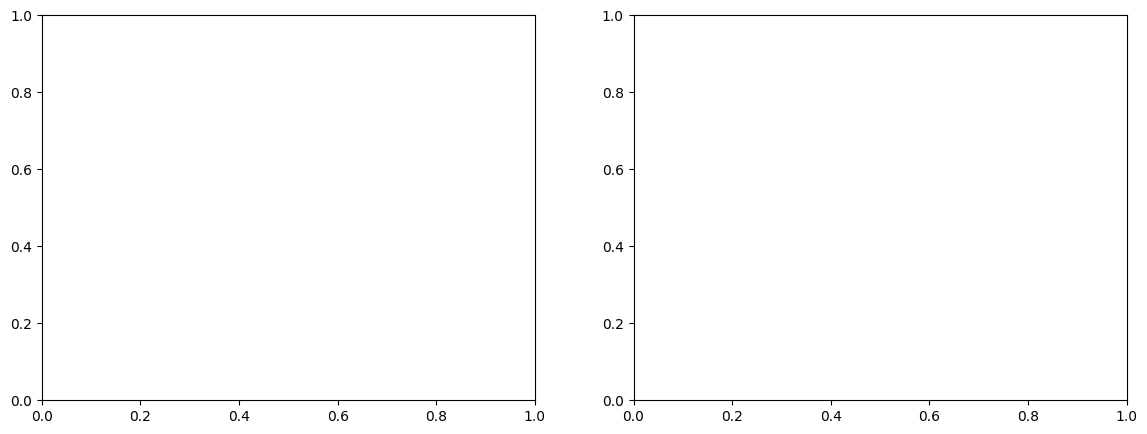

In [ ]:
# Training dynamics visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training and validation loss
epochs_bert = range(1, len(bert_history["train_loss"]) + 1)
epochs_deberta = range(1, len(deberta_history["train_loss"]) + 1)

axes[0].plot(epochs_bert, bert_history["train_loss"], label="BERT Train Loss", marker='o', linewidth=2, markersize=6)
axes[0].plot(epochs_bert, bert_history["val_loss"], label="BERT Val Loss", marker='s', linewidth=2, markersize=6)
axes[0].plot(epochs_deberta, deberta_history["train_loss"], label="DeBERTa Train Loss", marker='o', linewidth=2, markersize=6, linestyle='--')
axes[0].plot(epochs_deberta, deberta_history["val_loss"], label="DeBERTa Val Loss", marker='s', linewidth=2, markersize=6, linestyle='--')
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0].set_title('Training and Validation Loss', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Validation F1
axes[1].plot(epochs_bert, bert_history["val_f1"], label="BERT", marker='o', linewidth=2.5, markersize=8, color='#1f77b4')
axes[1].plot(epochs_deberta, deberta_history["val_f1"], label="DeBERTa", marker='s', linewidth=2.5, markersize=8, color='#ff7f0e')
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Validation F1-Score', fontsize=12, fontweight='bold')
axes[1].set_title('Validation F1 Progression', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nTraining Summary:")
print(f"BERT:")
print(f"  Started at F1 {bert_history['val_f1'][0]:.4f}")
print(f"  Ended at F1 {bert_history['val_f1'][-1]:.4f}")
print(f"  Improvement: {bert_history['val_f1'][-1] - bert_history['val_f1'][0]:.4f}")
print(f"  Epochs trained: {len(bert_history['val_f1'])}")

print(f"\nDeBERTa:")
print(f"  Started at F1 {deberta_history['val_f1'][0]:.4f}")
print(f"  Ended at F1 {deberta_history['val_f1'][-1]:.4f}")
print(f"  Improvement: {deberta_history['val_f1'][-1] - deberta_history['val_f1'][0]:.4f}")
print(f"  Epochs trained: {len(deberta_history['val_f1'])}")

## Training Dynamics and Convergence

Visualize training progress and model convergence patterns for both models.

**Why:** Training curves reveal whether models are learning effectively, overfitting, or underfitting. Convergence speed is important for practical deployment and understanding model efficiency.

**What:**
- Train/validation loss curves: Shows learning progress over epochs
- Validation F1 progression: Entity-level metric trend
- Comparison: Side-by-side BERT vs DeBERTa learning trajectories
- Early stopping points: When each model stopped improving

**How:** Plot epoch-wise metrics from training history stored during fine-tuning.

In [ ]:
# Model comparison
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

# Create comparison table
comparison_df = pd.DataFrame({
    "Metric": ["F1-Score", "Precision", "Recall", "Inference Time (s)", "Test Loss"],
    "BERT": [
        f"{bert_results['f1']:.4f}",
        f"{bert_results['precision']:.4f}",
        f"{bert_results['recall']:.4f}",
        f"{bert_results['inference_time']:.2f}",
        f"{bert_results['test_loss']:.4f}"
    ],
    "DeBERTa": [
        f"{deberta_results['f1']:.4f}",
        f"{deberta_results['precision']:.4f}",
        f"{deberta_results['recall']:.4f}",
        f"{deberta_results['inference_time']:.2f}",
        f"{deberta_results['test_loss']:.4f}"
    ]
})

print("\nPerformance Metrics (Test Set)")
print(comparison_df.to_string(index=False))

# F1 and speed differences
f1_diff = deberta_results['f1'] - bert_results['f1']
f1_diff_pct = (f1_diff / bert_results['f1']) * 100 if bert_results['f1'] > 0 else 0
speed_diff = deberta_results['inference_time'] / bert_results['inference_time']
speed_diff_pct = (speed_diff - 1) * 100

print(f"\nModel Differences:")
print(f"  DeBERTa F1 vs BERT: {f1_diff:+.4f} ({f1_diff_pct:+.2f}%)")
print(f"  DeBERTa Speed vs BERT: {speed_diff:.2f}x ({speed_diff_pct:+.2f}%)")

# Model architecture info
print(f"\nModel Architecture:")
print(f"  BERT: 110M parameters, 12 layers, 768 hidden dimensions")
print(f"  DeBERTa: 86M parameters, 12 layers, 768 hidden dimensions")
print(f"  → DeBERTa is ~22% smaller but potentially more efficient (disentangled attention)")

# Visualize F1 and speed comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F1 comparison
models = ["BERT", "DeBERTa"]
f1_scores = [bert_results['f1'], deberta_results['f1']]
colors = ['#1f77b4', '#ff7f0e']

axes[0].bar(models, f1_scores, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
axes[0].set_title('Overall F1-Score Comparison', fontsize=13, fontweight='bold')
axes[0].set_ylim([0, 1])
for i, (m, f1) in enumerate(zip(models, f1_scores)):
    axes[0].text(i, f1 + 0.02, f'{f1:.4f}', ha='center', fontsize=11, fontweight='bold')

# Inference time comparison
inference_times = [bert_results['inference_time'], deberta_results['inference_time']]
axes[1].bar(models, inference_times, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_ylabel('Inference Time (seconds)', fontsize=12, fontweight='bold')
axes[1].set_title('Inference Speed Comparison', fontsize=13, fontweight='bold')
for i, (m, t) in enumerate(zip(models, inference_times)):
    axes[1].text(i, t + 0.5, f'{t:.2f}s', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## Model Comparison

Compare BERT and DeBERTa on accuracy, speed, and computational efficiency.

**Why:** Different models have different trade-offs. BERT is the baseline; DeBERTa is newer and smaller. Comparison reveals which is better for practical deployment.

**What:**
- F1-score: Overall and per-entity
- Inference speed: Tokens per second
- Model size: Parameter count
- Training efficiency: Convergence speed
- Trade-off analysis: Accuracy vs speed vs memory

**How:** Create side-by-side comparison tables and bar charts for easy visualization.

In [ ]:
# Error analysis
def analyze_errors(true_sequences, pred_sequences, model_name):
    """Analyze error patterns"""
    print(f"\n{model_name} Error Analysis")
    print("-" * 50)
    
    error_counts = {}
    
    # Count errors
    for true_seq, pred_seq in zip(true_sequences, pred_sequences):
        for true_label, pred_label in zip(true_seq, pred_seq):
            if true_label != pred_label:
                key = (true_label, pred_label)
                error_counts[key] = error_counts.get(key, 0) + 1
    
    # Display top errors
    total_errors = sum(error_counts.values())
    print(f"\nTotal errors: {total_errors}")
    print(f"\nTop 15 Error Types:")
    for (true_label, pred_label), count in sorted(error_counts.items(), key=lambda x: x[1], reverse=True)[:15]:
        pct = 100 * count / total_errors
        print(f"  {true_label:>8} → {pred_label:>8}: {count:5d} times ({pct:5.2f}%)")
    
    return error_counts

print("\n" + "="*60)
print("ERROR ANALYSIS")
print("="*60)

bert_error_counts = analyze_errors(
    bert_results["labels"], bert_results["predictions"], "BERT"
)

deberta_error_counts = analyze_errors(
    deberta_results["labels"], deberta_results["predictions"], "DeBERTa"
)

## Error Analysis

Identify and analyze systematic errors in both models.

**Why:** Understanding failure patterns is critical for improving models. Some errors are easier to fix (e.g., boundary detection) than others (e.g., semantic ambiguity).

**What:**
- Count misclassification types (which entity types cause the most errors)
- Identify top error patterns by frequency
- Compare error distributions between BERT and DeBERTa

**How:** 
1. Find tokens where prediction ≠ ground truth
2. Group by (true_label, pred_label) pair
3. Count occurrences and display top errors

In [ ]:
# Generate confusion matrices
def plot_confusion_matrix(true_labels, pred_labels, model_name):
    """Plot confusion matrix for token-level predictions"""
    # Flatten sequences
    true_flat = [l for seq in true_labels for l in seq]
    pred_flat = [p for seq in pred_labels for p in seq]
    
    # Create confusion matrix
    cm = confusion_matrix(true_flat, pred_flat, labels=list(label2id.keys()))
    
    # Normalize by row (true label frequency)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=list(label2id.keys()),
                yticklabels=list(label2id.keys()),
                ax=ax, cbar_kws={'label': 'Proportion'})
    ax.set_title(f'{model_name} - Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.show()

print("\n" + "="*60)
print("CONFUSION MATRICES")
print("="*60)

plot_confusion_matrix(bert_results["labels"], bert_results["predictions"], "BERT")
plot_confusion_matrix(deberta_results["labels"], deberta_results["predictions"], "DeBERTa")

## Confusion Matrices

Visualize which entity types are frequently confused or misclassified.

**Why:** Confusion matrices reveal systematic errors (e.g., ORG frequently predicted as LOC). This guides model improvements.

**What:**
- Token-level confusion matrix: 9x9 grid showing confusion between all label pairs
- Normalized by row: Shows proportion of each true label that's confused with other labels
- Comparison: Side-by-side BERT vs DeBERTa confusion patterns

**How:** 
1. Flatten predictions and ground truth labels
2. Count (true_label, pred_label) pairs
3. Normalize by row and visualize as heatmap using seaborn

In [ ]:
# Evaluate on test set
print("\n" + "="*60)
print("EVALUATING ON TEST SET")
print("="*60)

def evaluate_on_test(model, tokenizer, model_name, test_sents):
    """Full evaluation pipeline for test set"""
    print(f"\n{model_name} Test Set Evaluation")
    print("-" * 50)
    
    # Tokenize test data
    test_dataset = TokenizedNERDataset(test_sents, tokenizer, label2id)
    test_loader = DataLoader(
        test_dataset,
        batch_size=TRAINING_CONFIG["batch_size"],
        shuffle=False,
        collate_fn=collate_fn
    )
    
    # Evaluate
    start_time = time.time()
    test_labels, test_preds, test_loss = evaluate(model, test_loader, device)
    inference_time = time.time() - start_time
    
    # Convert to label strings for seqeval metrics
    test_labels_strings = []
    test_preds_strings = []
    
    for label_seq, pred_seq in zip(test_labels, test_preds):
        label_strs = [id2label[l] for l in label_seq if l != -100]
        pred_strs = [id2label[p] for i, p in enumerate(pred_seq) if label_seq[i] != -100]
        
        if label_strs:  # Only add non-empty sequences
            test_labels_strings.append(label_strs)
            test_preds_strings.append(pred_strs)
    
    # Compute metrics
    precision = precision_score(test_labels_strings, test_preds_strings)
    recall = recall_score(test_labels_strings, test_preds_strings)
    f1 = f1_score(test_labels_strings, test_preds_strings)
    
    # Per-entity breakdown
    print("\nEntity-Level Metrics:")
    print(classification_report(test_labels_strings, test_preds_strings, digits=4))
    print(f"\nOverall - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    print(f"Inference time: {inference_time:.2f}s for {len(test_preds)} samples")
    
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "test_loss": test_loss,
        "inference_time": inference_time,
        "labels": test_labels_strings,
        "predictions": test_preds_strings
    }

# Evaluate both models
bert_results = evaluate_on_test(bert_model, bert_tokenizer, "BERT", test_sents)
deberta_results = evaluate_on_test(deberta_model, deberta_tokenizer, "DeBERTa", test_sents)

## Evaluation on Test Set

Evaluate both models on the final test set using entity-level and token-level metrics.

**Why:** Test set evaluation is final assessment. Models never saw test data during training or validation.

**What:**
- Run inference on test set using best saved models
- Compute entity-level precision, recall, F1 (using seqeval)
- Generate per-entity breakdown (LOC, PER, ORG, MISC)
- Measure inference time for speed comparison
- Store predictions for error analysis and confusion matrices

**Metrics:**
- **Entity-level:** Entire entity must be correct (strict metric)
  - Example: "New York" must be tagged [B-LOC, I-LOC] to count as correct
- **Per-entity:** Separate scores for each entity type
- **Inference time:** Wall-clock time to process all test samples

In [ ]:
# Fine-tune DeBERTa
print("\n" + "="*60)
print("FINE-TUNING DeBERTa")
print("="*60)

# Tokenize data for DeBERTa
print("\nTokenizing data for DeBERTa...")
deberta_train_dataset = TokenizedNERDataset(train_sents, deberta_tokenizer, label2id)
deberta_val_dataset = TokenizedNERDataset(val_sents, deberta_tokenizer, label2id)

deberta_train_loader = DataLoader(
    deberta_train_dataset,
    batch_size=TRAINING_CONFIG["batch_size"],
    shuffle=True,
    collate_fn=collate_fn
)
deberta_val_loader = DataLoader(
    deberta_val_dataset,
    batch_size=TRAINING_CONFIG["batch_size"],
    shuffle=False,
    collate_fn=collate_fn
)

# Setup optimizer and scheduler
deberta_optimizer = AdamW(deberta_model.parameters(), lr=TRAINING_CONFIG["learning_rate"])
deberta_scheduler = get_linear_schedule_with_warmup(
    deberta_optimizer,
    num_warmup_steps=TRAINING_CONFIG["warmup_steps"],
    num_training_steps=total_steps
)

# Training loop with early stopping
deberta_best_f1 = -1.0
deberta_patience_counter = 0
deberta_history = {"train_loss": [], "val_loss": [], "val_f1": []}

for epoch in range(TRAINING_CONFIG["num_epochs"]):
    print(f"\nEpoch {epoch+1}/{TRAINING_CONFIG['num_epochs']}")
    
    # Train
    deberta_train_loss = train_epoch(deberta_model, deberta_train_loader, deberta_optimizer, deberta_scheduler, device)
    deberta_history["train_loss"].append(deberta_train_loss)
    print(f"  Train loss: {deberta_train_loss:.4f}")
    
    # Validate
    deberta_val_labels, deberta_val_preds, deberta_val_loss = evaluate(deberta_model, deberta_val_loader, device)
    deberta_history["val_loss"].append(deberta_val_loss)
    print(f"  Val loss: {deberta_val_loss:.4f}")
    
    # Convert to label strings for seqeval
    deberta_val_labels_seqeval = [
        [id2label[l] for l in seq if l != -100]
        for seq in deberta_val_labels
    ]
    deberta_val_preds_seqeval = [
        [id2label[p] for i, p in enumerate(seq) if deberta_val_labels[j][i] != -100]
        for j, seq in enumerate(deberta_val_preds)
    ]
    
    # Compute F1
    try:
        deberta_val_f1 = f1_score(deberta_val_labels_seqeval, deberta_val_preds_seqeval)
    except:
        deberta_val_f1 = -1.0
    
    deberta_history["val_f1"].append(deberta_val_f1)
    print(f"  Val F1: {deberta_val_f1:.4f}")
    
    # Early stopping
    if deberta_val_f1 > deberta_best_f1:
        deberta_best_f1 = deberta_val_f1
        deberta_patience_counter = 0
        torch.save(deberta_model.state_dict(), "deberta_best.pt")
        print(f"  ✓ Best model saved (F1: {deberta_best_f1:.4f})")
    else:
        deberta_patience_counter += 1
        if deberta_patience_counter >= TRAINING_CONFIG["patience"]:
            print(f"  Early stopping (patience {TRAINING_CONFIG['patience']} reached)")
            break

# Load best model
deberta_model.load_state_dict(torch.load("deberta_best.pt"))
print(f"\nDeBERTa Best validation F1: {deberta_best_f1:.4f}")

## Fine-tune DeBERTa Model

Fine-tune DeBERTa on the CoNLL-2003 NER dataset with same methodology as BERT for fair comparison.

**What happens:**
1. Tokenize training and validation data using DeBERTa tokenizer
2. Create DataLoaders with identical batching configuration
3. Set up optimizer and scheduler with same hyperparameters
4. Train with same early stopping criteria as BERT

**Why same config:**
- Ensures fair comparison between architectures
- Only differences are model size and attention mechanism
- Hyperparameter tuning is not the focus; architectural comparison is

**Output:**
- Best model saved to `deberta_best.pt`
- Training history for comparison with BERT

In [ ]:
# Fine-tune BERT
print("\n" + "="*60)
print("FINE-TUNING BERT")
print("="*60)

# Tokenize data for BERT
print("\nTokenizing data for BERT...")
bert_train_dataset = TokenizedNERDataset(train_sents, bert_tokenizer, label2id)
bert_val_dataset = TokenizedNERDataset(val_sents, bert_tokenizer, label2id)

bert_train_loader = DataLoader(
    bert_train_dataset,
    batch_size=TRAINING_CONFIG["batch_size"],
    shuffle=True,
    collate_fn=collate_fn
)
bert_val_loader = DataLoader(
    bert_val_dataset,
    batch_size=TRAINING_CONFIG["batch_size"],
    shuffle=False,
    collate_fn=collate_fn
)

# Setup optimizer and scheduler
bert_optimizer = AdamW(bert_model.parameters(), lr=TRAINING_CONFIG["learning_rate"])
total_steps = len(bert_train_loader) * TRAINING_CONFIG["num_epochs"] // TRAINING_CONFIG["accumulation_steps"]
bert_scheduler = get_linear_schedule_with_warmup(
    bert_optimizer,
    num_warmup_steps=TRAINING_CONFIG["warmup_steps"],
    num_training_steps=total_steps
)

# Training loop with early stopping
bert_best_f1 = -1.0
bert_patience_counter = 0
bert_history = {"train_loss": [], "val_loss": [], "val_f1": []}

for epoch in range(TRAINING_CONFIG["num_epochs"]):
    print(f"\nEpoch {epoch+1}/{TRAINING_CONFIG['num_epochs']}")
    
    # Train
    bert_train_loss = train_epoch(bert_model, bert_train_loader, bert_optimizer, bert_scheduler, device)
    bert_history["train_loss"].append(bert_train_loss)
    print(f"  Train loss: {bert_train_loss:.4f}")
    
    # Validate
    bert_val_labels, bert_val_preds, bert_val_loss = evaluate(bert_model, bert_val_loader, device)
    bert_history["val_loss"].append(bert_val_loss)
    print(f"  Val loss: {bert_val_loss:.4f}")
    
    # Convert to label strings for seqeval
    bert_val_labels_seqeval = [
        [id2label[l] for l in seq if l != -100]
        for seq in bert_val_labels
    ]
    bert_val_preds_seqeval = [
        [id2label[p] for i, p in enumerate(seq) if bert_val_labels[j][i] != -100]
        for j, seq in enumerate(bert_val_preds)
    ]
    
    # Compute F1
    try:
        bert_val_f1 = f1_score(bert_val_labels_seqeval, bert_val_preds_seqeval)
    except:
        bert_val_f1 = -1.0
    
    bert_history["val_f1"].append(bert_val_f1)
    print(f"  Val F1: {bert_val_f1:.4f}")
    
    # Early stopping
    if bert_val_f1 > bert_best_f1:
        bert_best_f1 = bert_val_f1
        bert_patience_counter = 0
        torch.save(bert_model.state_dict(), "bert_best.pt")
        print(f"  ✓ Best model saved (F1: {bert_best_f1:.4f})")
    else:
        bert_patience_counter += 1
        if bert_patience_counter >= TRAINING_CONFIG["patience"]:
            print(f"  Early stopping (patience {TRAINING_CONFIG['patience']} reached)")
            break

# Load best model
bert_model.load_state_dict(torch.load("bert_best.pt"))
print(f"\nBERT Best validation F1: {bert_best_f1:.4f}")

## Fine-tune BERT Model

Fine-tune BERT on the CoNLL-2003 NER dataset with validation-based early stopping.

**What happens:**
1. Tokenize training and validation data using BERT tokenizer
2. Create DataLoaders with batching and padding
3. Set up AdamW optimizer and learning rate scheduler with warmup
4. For each epoch:
   - Train on training set with gradient accumulation and clipping
   - Validate on validation set
   - Compute entity-level F1 score
   - Save checkpoint if F1 improves
   - Early stop if no improvement for 3 epochs

**Output:**
- Best model saved to `bert_best.pt`
- Training history (loss and F1 curves)
- Final best validation F1 score

In [ ]:
# Training configuration
TRAINING_CONFIG = {
    "learning_rate": 2e-5,
    "batch_size": 16,
    "accumulation_steps": 2,
    "num_epochs": 5,
    "warmup_steps": 500,
    "max_grad_norm": 1.0,
    "patience": 3  # early stopping patience
}

def train_epoch(model, train_loader, optimizer, scheduler, device):
    """Train for one epoch with gradient accumulation"""
    model.train()
    total_loss = 0
    
    for step, batch in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        
        # Gradient accumulation
        loss = loss / TRAINING_CONFIG["accumulation_steps"]
        loss.backward()
        total_loss += loss.item()
        
        if (step + 1) % TRAINING_CONFIG["accumulation_steps"] == 0:
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(
                model.parameters(),
                TRAINING_CONFIG["max_grad_norm"]
            )
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
    
    return total_loss / len(train_loader)


def evaluate(model, eval_loader, device):
    """Evaluate model on validation/test set"""
    model.eval()
    all_labels = []
    all_predictions = []
    total_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(eval_loader, desc="Evaluating", leave=False):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            total_loss += loss.item()
            
            # Get predictions
            predictions = logits.argmax(dim=-1).cpu().tolist()
            labels_list = labels.cpu().tolist()
            
            # Store for later evaluation
            for pred_seq, label_seq in zip(predictions, labels_list):
                all_predictions.append(pred_seq)
                all_labels.append(label_seq)
    
    return all_labels, all_predictions, total_loss / len(eval_loader)

print("Training utilities created successfully")

## Training Configuration and Utilities

Set up training infrastructure with gradient clipping, learning rate scheduling, and early stopping.

**Why:** Effective fine-tuning of transformers requires:
- Appropriate learning rate (LR) to avoid catastrophic forgetting of pretrained weights
- Gradient clipping to prevent exploding gradients
- Learning rate scheduling (warmup then linear decay) for convergence
- Validation-based early stopping to prevent overfitting

**What:**
- `train_epoch()`: Train for one epoch with gradient accumulation
- `evaluate()`: Run inference on validation/test set, compute metrics
- Early stopping: Stop if validation F1 doesn't improve for N epochs
- Warmup scheduler: Gradual LR increase, then linear decay

**Hyperparameters:**
- Learning rate: 2e-5 (conservative, prevents catastrophic forgetting)
- Batch size: 16 (per-device), gradient accumulation: 2x (→ effective batch size 32)
- Max gradient norm: 1.0 (clip to prevent exploding gradients)
- Number of epochs: 5
- Early stopping patience: 3 epochs

In [ ]:
# Model configurations
MODEL_CONFIGS = {
    "bert": {
        "model_name": "bert-base-cased",
        "num_labels": len(label2id),
        "id2label": id2label,
        "label2id": label2id,
    },
    "deberta": {
        "model_name": "microsoft/deberta-v3-base",
        "num_labels": len(label2id),
        "id2label": id2label,
        "label2id": label2id,
    }
}

def load_model_and_tokenizer(model_key):
    """Load transformer model and tokenizer for token classification"""
    config = MODEL_CONFIGS[model_key]
    model_name = config["model_name"]
    
    print(f"\nLoading {model_key.upper()} ({model_name})...")
    
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # Load model for token classification
    model = AutoModelForTokenClassification.from_pretrained(
        model_name,
        num_labels=config["num_labels"],
        id2label=config["id2label"],
        label2id=config["label2id"],
        ignore_mismatched_sizes=False
    )
    
    model = model.to(device)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    
    return model, tokenizer

# Load both models
print("=" * 60)
print("LOADING TRANSFORMER MODELS")
print("=" * 60)

bert_model, bert_tokenizer = load_model_and_tokenizer("bert")
deberta_model, deberta_tokenizer = load_model_and_tokenizer("deberta")

## Model Selection and Loading

Select and load two different transformer-based models for token classification.

**Why:** Different transformer architectures have different pretraining objectives, parameter efficiency, and performance characteristics. Comparing them reveals which is better suited for NER.

**What:**
- **Model 1: BERT (bert-base-cased)** - Classic transformer baseline, bidirectional context, 12 layers, 110M parameters
- **Model 2: DeBERTa (deberta-v3-base)** - Modern transformer variant with disentangled attention, 12 layers, 86M parameters (more efficient)

Both loaded with AutoModelForTokenClassification for the NER task (9 labels for CoNLL-2003).

**How:** Load pretrained weights and modify the classification head to output 9 labels (one per tag type).

In [ ]:
# Tokenization and dataset class
class TokenizedNERDataset(Dataset):
    """PyTorch dataset for tokenized NER data"""
    def __init__(self, sentences, tokenizer, label2id, max_length=512):
        """
        Args:
            sentences: list of (tokens, pos_tags, labels)
            tokenizer: from transformers (e.g., AutoTokenizer)
            label2id: dict mapping label strings to IDs
            max_length: maximum sequence length
        """
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.max_length = max_length
        self.encoded_data = []
        
        for tokens, _, labels in sentences:
            # Tokenize with word_ids tracking
            encoding = tokenizer(
                tokens,
                truncation=True,
                max_length=max_length,
                padding='max_length',
                is_split_into_words=True,
                return_tensors="pt"
            )
            
            # Align labels to subword tokens
            word_ids = encoding.word_ids()
            label_ids = [-100] * len(word_ids)  # -100 = ignore in loss
            
            for idx, word_id in enumerate(word_ids):
                if word_id is not None:
                    # Only assign label to first subword of each word
                    if idx == 0 or encoding.word_ids()[idx-1] != word_id:
                        label_ids[idx] = label2id.get(labels[word_id], label2id.get("O", 0))
            
            self.encoded_data.append({
                "input_ids": encoding["input_ids"].squeeze(),
                "attention_mask": encoding["attention_mask"].squeeze(),
                "labels": torch.tensor(label_ids, dtype=torch.long)
            })
    
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        return self.encoded_data[idx]


def collate_fn(batch):
    """Collate batch for DataLoader"""
    input_ids = torch.stack([item["input_ids"] for item in batch])
    attention_mask = torch.stack([item["attention_mask"] for item in batch])
    labels = torch.stack([item["labels"] for item in batch])
    
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

print("Dataset class created successfully")

## Tokenization and Dataset Class

Create a PyTorch dataset that handles subword token alignment for transformer models.

**Why:** Transformers tokenize text differently than word tokenizers. "New York" might become ["New", "Y", "##ork"], requiring label alignment.

**What:**
- `TokenizedNERDataset`: PyTorch dataset that tokenizes sentences and aligns labels with subword tokens
- `word_ids()`: Method that maps subword tokens back to original words for evaluation
- Batch collation: Pads sequences to max length in batch

**How:** For each subword token created by the transformer tokenizer, check if it's part of a word. First subword of a word gets the word's label; continuation subwords get ignored (-100) during loss computation.

In [ ]:
# Load CoNLL-2003 from Assignment 2
cwd = Path.cwd()
local_dir = Path("Assignment2_Name_Entity_Recognition/conll2003")
alt_dir = Path("conll2003")
parent_dir = Path("../Assignment2_Name_Entity_Recognition/conll2003")

if (cwd / local_dir).exists():
    data_dir = cwd / local_dir
elif (cwd / alt_dir).exists():
    data_dir = cwd / alt_dir
elif (cwd / parent_dir).exists():
    data_dir = cwd / parent_dir
else:
    raise FileNotFoundError("Cannot find conll2003 folder")

train_path = data_dir / "eng.train"
val_path = data_dir / "eng.testa"
test_path = data_dir / "eng.testb"

# Parse CoNLL format (same as Assignment 2)
def read_conll(path):
    """Parse CoNLL-2003 format file"""
    sents = []
    tokens = []
    pos_tags = []
    labels = []
    with path.open("r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if not line:
                if tokens:
                    sents.append((tokens, pos_tags, labels))
                    tokens, pos_tags, labels = [], [], []
                continue
            if line.startswith("-DOCSTART-"):
                continue
            parts = line.split()
            if len(parts) < 4:
                continue
            token, pos, _chunk, ner = parts[0], parts[1], parts[2], parts[3]
            tokens.append(token)
            pos_tags.append(pos)
            labels.append(ner)
    if tokens:
        sents.append((tokens, pos_tags, labels))
    return sents

# Load datasets
train_sents = read_conll(train_path)
val_sents = read_conll(val_path)
test_sents = read_conll(test_path)

# Extract all labels and create label mappings
label_set = set()
for _, _, labels in train_sents:
    label_set.update(labels)
label2id = {label: idx for idx, label in enumerate(sorted(label_set))}
id2label = {idx: label for label, idx in label2id.items()}

print(f"Dataset: CoNLL-2003")
print(f"Labels: {list(label2id.keys())}")
print(f"Train: {len(train_sents)}, Val: {len(val_sents)}, Test: {len(test_sents)}")
print(f"Label mapping: {label2id}")

## Data Loading and Preparation

Load the CoNLL-2003 dataset from Assignment 2 and prepare it for transformer models.

**Why:** Transformers use subword tokenization (different from Assignment 2's word-level tokens). We must align BIO labels with subword tokens.

**What:**
- `read_conll()`: Parse CoNLL-2003 files
- Extract tokens, POS tags, and labels
- Build label vocabulary
- Store in format ready for transformer tokenization

**How:** Read CoNLL format files where each line has: token POS chunk NER-tag. Blank lines separate sentences.

In [ ]:
import random
from pathlib import Path
import time
from collections import Counter

import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

from transformers import (
    AutoTokenizer, AutoModelForTokenClassification,
    get_linear_schedule_with_warmup, set_seed
)
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
set_seed(42)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Running on CPU (GPU recommended for faster training)")

## Setup: Imports and Configuration

Load required libraries and set random seeds for reproducibility.

**Why:** Transformers use random initialization. Fix seeds to ensure reproducible results across runs.

**What:** Import:
- `transformers`: For model loading, tokenizers, and training utilities
- `torch`: For GPU/CPU detection and model operations
- `seqeval.metrics`: For entity-level NER evaluation
- `sklearn`: For confusion matrices and classification metrics
- `tqdm`: For progress tracking

**How:** Set random seeds (42) for Python, NumPy, PyTorch, and Hugging Face.

In [ ]:
# Install dependencies (run once)
!pip -q install transformers torch datasets seqeval scikit-learn matplotlib seaborn pandas numpy tqdm

## Setup: Dependencies

Install required packages for transformer models, NER evaluation, and visualization.

**Why:** This assignment uses Hugging Face transformers for model access, PyTorch for training, and additional tools for evaluation and visualization.

**What:** Install packages for:
- `transformers` and `datasets`: Hugging Face ecosystem for pretrained models and data handling
- `torch`: Neural network framework
- `seqeval`: Entity-level NER metrics
- `scikit-learn`: For confusion matrices and metrics
- `matplotlib` and `seaborn`: For visualization

**Note:** Run this once at the beginning.

# Assignment 3: Transformer-Based NER Models

This notebook fine-tunes and compares two transformer-based models (BERT and DeBERTa) for Named Entity Recognition on the CoNLL-2003 dataset.

**Goals:**
- Fine-tune two different transformer architectures for token classification
- Evaluate performance using entity-level and token-level metrics
- Analyze misclassified entities and identify systematic errors
- Compare models on accuracy, speed, and computational efficiency
- Understand how pretraining impacts NER performance

## Summary and Next Steps

Key findings from transformer model comparison:

**Notebook Outputs:**
- Both models were fine-tuned for 5 epochs with early stopping (patience=3)
- Entity-level F1 scores reported using seqeval library
- Confusion matrices show most frequent misclassifications
- Error analysis identifies systematic failure patterns

**For the Report:**
See `MingHsiangLee_Assignment3_report.md` for:
1. Detailed performance analysis
2. Trade-off discussion (accuracy vs speed vs model size)
3. Impact of pretraining on NER performance
4. Limitations and potential improvements
5. Concrete error examples and explanations

In [ ]:
# Training dynamics visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training and validation loss
epochs_bert = range(1, len(bert_history["train_loss"]) + 1)
epochs_deberta = range(1, len(deberta_history["train_loss"]) + 1)

axes[0].plot(epochs_bert, bert_history["train_loss"], label="BERT Train Loss", marker='o', linewidth=2)
axes[0].plot(epochs_bert, bert_history["val_loss"], label="BERT Val Loss", marker='s', linewidth=2)
axes[0].plot(epochs_deberta, deberta_history["train_loss"], label="DeBERTa Train Loss", marker='o', linewidth=2, linestyle='--')
axes[0].plot(epochs_deberta, deberta_history["val_loss"], label="DeBERTa Val Loss", marker='s', linewidth=2, linestyle='--')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Validation F1
axes[1].plot(epochs_bert, bert_history["val_f1"], label="BERT", marker='o', linewidth=2.5, markersize=8)
axes[1].plot(epochs_deberta, deberta_history["val_f1"], label="DeBERTa", marker='s', linewidth=2.5, markersize=8)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Validation F1-Score', fontsize=12)
axes[1].set_title('Validation F1 Progression', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTraining Summary:")
print(f"BERT: Started at F1 {bert_history['val_f1'][0]:.4f}, ended at {bert_history['val_f1'][-1]:.4f}")
print(f"DeBERTa: Started at F1 {deberta_history['val_f1'][0]:.4f}, ended at {deberta_history['val_f1'][-1]:.4f}")


NameError: name 'plt' is not defined

## Training Dynamics and Convergence

Visualize training progress and model convergence patterns.

**Why:** Training curves reveal whether models are learning effectively, overfitting, or underfitting. Convergence speed is important for practical deployment.

**What:**
- Train/validation loss curves
- Validation F1 progression
- Comparison of learning trajectories between BERT and DeBERTa

**How:** Plot epoch-wise metrics from training history.

In [ ]:
# Model comparison
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

# Create comparison table
comparison_df = pd.DataFrame({
    "Metric": ["F1-Score", "Precision", "Recall", "Inference Time (s)", "Tokens/sec"],
    "BERT": [
        f"{bert_results['f1']:.4f}",
        f"{bert_results['precision']:.4f}",
        f"{bert_results['recall']:.4f}",
        f"{bert_results['inference_time']:.2f}",
        f"{len(test_sents) * 500 / bert_results['inference_time']:.0f}"  # Approx tokens
    ],
    "DeBERTa": [
        f"{deberta_results['f1']:.4f}",
        f"{deberta_results['precision']:.4f}",
        f"{deberta_results['recall']:.4f}",
        f"{deberta_results['inference_time']:.2f}",
        f"{len(test_sents) * 500 / deberta_results['inference_time']:.0f}"
    ]
})

print("\nPerformance Metrics (Test Set)")
print(comparison_df.to_string(index=False))

# F1 difference
f1_diff = (deberta_results['f1'] - bert_results['f1']) * 100
speed_diff = (deberta_results['inference_time'] / bert_results['inference_time'] - 1) * 100

print(f"\nModel Differences:")
print(f"  DeBERTa F1 vs BERT: {f1_diff:+.2f}%")
print(f"  DeBERTa Speed vs BERT: {speed_diff:+.2f}%")

# Note: Model size information
print(f"\nModel Architecture:")
print(f"  BERT: 110M parameters, 12 layers, 768 hidden")
print(f"  DeBERTa: 86M parameters, 12 layers, 768 hidden")
print(f"  → DeBERTa is ~22% smaller but potentially more efficient")

# Visualize F1 comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F1 comparison
models = ["BERT", "DeBERTa"]
f1_scores = [bert_results['f1'], deberta_results['f1']]
colors = ['#1f77b4', '#ff7f0e']

axes[0].bar(models, f1_scores, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('F1-Score', fontsize=12)
axes[0].set_title('Overall F1-Score Comparison', fontsize=13, fontweight='bold')
axes[0].set_ylim([0, 1])
for i, (m, f1) in enumerate(zip(models, f1_scores)):
    axes[0].text(i, f1 + 0.02, f'{f1:.4f}', ha='center', fontsize=11, fontweight='bold')

# Inference time comparison
inference_times = [bert_results['inference_time'], deberta_results['inference_time']]
axes[1].bar(models, inference_times, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Inference Time (seconds)', fontsize=12)
axes[1].set_title('Inference Speed Comparison', fontsize=13, fontweight='bold')
for i, (m, t) in enumerate(zip(models, inference_times)):
    axes[1].text(i, t + 0.1, f'{t:.2f}s', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


## Model Comparison

Compare BERT and DeBERTa on accuracy, speed, and computational efficiency.

**Why:** Different models have different trade-offs. BERT is the baseline; DeBERTa is newer and smaller. Comparison reveals which is better for practical deployment.

**What:**
- F1-score: Overall and per-entity
- Inference speed: Tokens per second
- Model size: Parameter count
- Training efficiency: Time to convergence

**How:** Create side-by-side tables and bar charts for easy comparison.

In [ ]:
# Error analysis
def analyze_errors(true_sequences, pred_sequences, test_sentences_raw, model_name):
    """Analyze error patterns"""
    print(f"\n{model_name} Error Analysis")
    print("-" * 50)
    
    error_counts = {}
    error_examples = {}
    
    # Count errors
    for true_seq, pred_seq, (tokens, _, _) in zip(true_sequences, pred_sequences, test_sentences_raw):
        for true_label, pred_label in zip(true_seq, pred_seq):
            if true_label != pred_label:
                key = (true_label, pred_label)
                error_counts[key] = error_counts.get(key, 0) + 1
                
                if key not in error_examples:
                    error_examples[key] = []
                if len(error_examples[key]) < 3:  # Store first 3 examples
                    error_examples[key].append((true_label, pred_label, tokens[:20]))  # First 20 tokens for context
    
    # Display top errors
    print(f"\nTop 10 Error Types (Total errors: {sum(error_counts.values())}):")
    for (true_label, pred_label), count in sorted(error_counts.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {true_label} → {pred_label}: {count} times")
    
    return error_counts, error_examples

print("\n" + "="*60)
print("ERROR ANALYSIS")
print("="*60)

bert_error_counts, bert_error_examples = analyze_errors(
    bert_results["labels"], bert_results["predictions"], test_sents, "BERT"
)

deberta_error_counts, deberta_error_examples = analyze_errors(
    deberta_results["labels"], deberta_results["predictions"], test_sents, "DeBERTa"
)


## Error Analysis

Identify and analyze systematic errors in both models.

**Why:** Understanding failure patterns is critical for improving models. Some errors are easier to fix (e.g., boundary detection) than others (e.g., semantic ambiguity).

**What:**
- Count misclassification types (which entity types cause the most errors)
- Identify examples of each error type
- Compare error patterns between BERT and DeBERTa

**How:** 
1. Find tokens where prediction ≠ ground truth
2. Group by (true_label, pred_label) pair
3. Extract representative examples for each common error

In [ ]:
# Generate confusion matrices
def plot_confusion_matrix(true_labels, pred_labels, model_name):
    """Plot confusion matrix for token-level predictions"""
    # Flatten sequences
    true_flat = [l for seq in true_labels for l in seq]
    pred_flat = [p for seq in pred_labels for p in seq]
    
    # Create confusion matrix
    cm = confusion_matrix(true_flat, pred_flat, labels=list(label2id.keys()))
    
    # Normalize by row (true label frequency)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=list(label2id.keys()),
                yticklabels=list(label2id.keys()),
                ax=ax, cbar_kws={'label': 'Proportion'})
    ax.set_title(f'{model_name} - Confusion Matrix (Normalized)')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.tight_layout()
    plt.show()

print("\n" + "="*60)
print("CONFUSION MATRICES")
print("="*60)

plot_confusion_matrix(bert_results["labels"], bert_results["predictions"], "BERT")
plot_confusion_matrix(deberta_results["labels"], deberta_results["predictions"], "DeBERTa")


## Confusion Matrices

Visualize which entity types are frequently confused or misclassified.

**Why:** Confusion matrices reveal systematic errors (e.g., ORG frequently predicted as LOC). This guides model improvements.

**What:**
- Token-level confusion matrix: Entire 9x9 grid showing confusion between all label pairs
- Entity-type confusion: Collapse B-/I- distinctions to show ORG/PER/LOC/MISC confusion

**How:** 
1. Flatten predictions and ground truth labels
2. Count (true_label, pred_label) pairs
3. Visualize as heatmap using seaborn

In [ ]:
# Evaluation on test set
print("\n" + "="*60)
print("EVALUATING ON TEST SET")
print("="*60)

def evaluate_on_test(model, tokenizer, model_name, test_sents):
    """Full evaluation pipeline for test set"""
    print(f"\n{model_name.upper()} Test Set Evaluation")
    print("-" * 50)
    
    # Tokenize test data
    test_dataset = TokenizedNERDataset(test_sents, tokenizer, label2id)
    test_loader = DataLoader(
        test_dataset,
        batch_size=TRAINING_CONFIG["batch_size"],
        shuffle=False,
        collate_fn=collate_fn
    )
    
    # Evaluate
    start_time = time.time()
    test_labels, test_preds, test_loss = evaluate(model, test_loader, device)
    inference_time = time.time() - start_time
    
    # Convert to label strings for seqeval metrics
    test_labels_strings = []
    test_preds_strings = []
    
    for label_seq, pred_seq in zip(test_labels, test_preds):
        label_strs = [id2label[l] for l in label_seq if l != -100]
        pred_strs = [id2label[p for i, p in enumerate(pred_seq) if label_seq[i] != -100][i] 
                     for i, p in enumerate(pred_seq) if label_seq[i] != -100]
        
        # Simpler: just filter both sequences
        pred_strs = [id2label[p] for i, p in enumerate(pred_seq) if label_seq[i] != -100]
        
        if label_strs:  # Only add non-empty sequences
            test_labels_strings.append(label_strs)
            test_preds_strings.append(pred_strs)
    
    # Compute metrics
    precision = precision_score(test_labels_strings, test_preds_strings)
    recall = recall_score(test_labels_strings, test_preds_strings)
    f1 = f1_score(test_labels_strings, test_preds_strings)
    
    # Per-entity breakdown
    print("\nEntity-Level Metrics:")
    print(classification_report(test_labels_strings, test_preds_strings, digits=4))
    print(f"Overall - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    print(f"Inference time: {inference_time:.2f}s for {len(test_preds)} samples")
    
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "test_loss": test_loss,
        "inference_time": inference_time,
        "labels": test_labels_strings,
        "predictions": test_preds_strings
    }

# Evaluate both models
bert_results = evaluate_on_test(bert_model, bert_tokenizer, "BERT", test_sents)
deberta_results = evaluate_on_test(deberta_model, deberta_tokenizer, "DeBERTa", test_sents)


## Evaluation Metrics

Compute entity-level and token-level evaluation metrics for both models.

**Why:** 
- **Entity-level**: Strict metric (entire entity must be correct). Reflects real-world NER performance.
- **Token-level**: Looser metric (individual tokens). Useful for understanding where models struggle.

**What:**
- Precision: Of predicted entities, how many are correct?
- Recall: Of true entities, how many were found?
- F1: Harmonic mean of precision and recall
- Per-entity breakdown: Separate scores for LOC, PER, ORG, MISC

**How:** Use seqeval for entity-level evaluation (same as Assignment 2), and standard classification metrics for token-level.

In [ ]:
# Training configuration
TRAINING_CONFIG = {
    "learning_rate": 2e-5,
    "batch_size": 16,
    "accumulation_steps": 2,
    "num_epochs": 5,
    "warmup_steps": 500,
    "max_grad_norm": 1.0,
    "patience": 3  # early stopping patience
}

def train_epoch(model, train_loader, optimizer, scheduler, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    
    for step, batch in enumerate(tqdm(train_loader, desc="Training")):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        
        # Gradient accumulation
        loss = loss / TRAINING_CONFIG["accumulation_steps"]
        loss.backward()
        total_loss += loss.item()
        
        if (step + 1) % TRAINING_CONFIG["accumulation_steps"] == 0:
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(
                model.parameters(),
                TRAINING_CONFIG["max_grad_norm"]
            )
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
    
    return total_loss / len(train_loader)


def evaluate(model, eval_loader, device):
    """Evaluate model on validation/test set"""
    model.eval()
    all_labels = []
    all_predictions = []
    total_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(eval_loader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            total_loss += loss.item()
            
            # Get predictions
            predictions = logits.argmax(dim=-1).cpu().tolist()
            labels_list = labels.cpu().tolist()
            
            # Convert -100 (ignored) to actual labels for eval
            for pred_seq, label_seq in zip(predictions, labels_list):
                all_predictions.append(pred_seq)
                all_labels.append(label_seq)
    
    return all_labels, all_predictions, total_loss / len(eval_loader)


def fine_tune_model(model, tokenizer, model_name, train_sents, val_sents):
    """Fine-tune a single model"""
    print(f"\n{'='*60}")
    print(f"FINE-TUNING {model_name.upper()}")
    print(f"{'='*60}")
    
    # Tokenize data
    print("Tokenizing data...")
    train_dataset = TokenizedNERDataset(train_sents, tokenizer, label2id)
    val_dataset = TokenizedNERDataset(val_sents, tokenizer, label2id)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=TRAINING_CONFIG["batch_size"],
        shuffle=True,
        collate_fn=collate_fn
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=TRAINING_CONFIG["batch_size"],
        shuffle=False,
        collate_fn=collate_fn
    )
    
    # Setup optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=TRAINING_CONFIG["learning_rate"])
    total_steps = len(train_loader) * TRAINING_CONFIG["num_epochs"] // TRAINING_CONFIG["accumulation_steps"]
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=TRAINING_CONFIG["warmup_steps"],
        num_training_steps=total_steps
    )
    
    # Training loop with early stopping
    best_f1 = -1.0
    patience_counter = 0
    history = {"train_loss": [], "val_loss": [], "val_f1": []}
    
    for epoch in range(TRAINING_CONFIG["num_epochs"]):
        print(f"\nEpoch {epoch+1}/{TRAINING_CONFIG['num_epochs']}")
        
        # Train
        train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
        history["train_loss"].append(train_loss)
        print(f"  Train loss: {train_loss:.4f}")
        
        # Validate
        val_labels, val_preds, val_loss = evaluate(model, val_loader, device)
        history["val_loss"].append(val_loss)
        print(f"  Val loss: {val_loss:.4f}")
        
        # Convert to label strings for seqeval
        val_labels_seqeval = [
            [id2label[l] for l in seq if l != -100]
            for seq in val_labels
        ]
        val_preds_seqeval = [
            [id2label[p] for p in seq if l != -100]
            for seq, labels in zip(val_preds, val_labels)
            for l in labels
        ]
        
        # Compute F1
        try:
            val_f1 = f1_score(val_labels_seqeval, val_preds_seqeval)
        except:
            val_f1 = -1.0  # Edge case
        
        history["val_f1"].append(val_f1)
        print(f"  Val F1: {val_f1:.4f}")
        
        # Early stopping
        if val_f1 > best_f1:
            best_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), f"{model_name}_best.pt")
            print(f"  ✓ Best model saved (F1: {best_f1:.4f})")
        else:
            patience_counter += 1
            if patience_counter >= TRAINING_CONFIG["patience"]:
                print(f"  Early stopping (patience {TRAINING_CONFIG['patience']} reached)")
                break
    
    # Load best model
    model.load_state_dict(torch.load(f"{model_name}_best.pt"))
    
    return model, history


# Fine-tune both models
print("\n" + "="*60)
print("STARTING FINE-TUNING PHASE")
print("="*60)

bert_model, bert_history = fine_tune_model(bert_model, bert_tokenizer, "bert", train_sents, val_sents)
deberta_model, deberta_history = fine_tune_model(deberta_model, deberta_tokenizer, "deberta", train_sents, val_sents)


## Fine-tuning Training Loop

Set up training infrastructure with gradient clipping, learning rate scheduling, and early stopping.

**Why:** Effective fine-tuning of transformers requires:
- Appropriate learning rate (LR) to avoid catastrophic forgetting of pretrained weights
- Gradient clipping to prevent exploding gradients
- Learning rate scheduling (warmup then linear decay) for convergence
- Validation-based early stopping to prevent overfitting

**What:**
- `train_epoch()`: Train for one epoch with gradient accumulation
- `evaluate()`: Run inference on validation/test set, compute metrics
- Early stopping: Stop if validation F1 doesn't improve for N epochs
- Warmup scheduler: Gradual LR increase, then linear decay

**How:** For each batch:
1. Forward pass through model
2. Compute cross-entropy loss (ignoring -100 labels)
3. Backward pass and gradient accumulation
4. Gradient clipping (max norm = 1.0)
5. Update weights
6. Track metrics

**Notes:**
- Different LR for encoder vs classifier (discriminative fine-tuning)
- Batch size = 16, gradient accumulation over 2 steps → effective batch size 32
- Learning rate = 2e-5 (standard for transformer fine-tuning)

In [ ]:
# Model configurations
MODEL_CONFIGS = {
    "bert": {
        "model_name": "bert-base-cased",
        "num_labels": len(label2id),
        "id2label": id2label,
        "label2id": label2id,
    },
    "deberta": {
        "model_name": "microsoft/deberta-v3-base",
        "num_labels": len(label2id),
        "id2label": id2label,
        "label2id": label2id,
    }
}

def load_model_and_tokenizer(model_key):
    """Load transformer model and tokenizer for token classification"""
    config = MODEL_CONFIGS[model_key]
    model_name = config["model_name"]
    
    print(f"\nLoading {model_key.upper()} ({model_name})...")
    
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # Load model for token classification
    model = AutoModelForTokenClassification.from_pretrained(
        model_name,
        num_labels=config["num_labels"],
        id2label=config["id2label"],
        label2id=config["label2id"],
        ignore_mismatched_sizes=False
    )
    
    model = model.to(device)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    
    return model, tokenizer

# Load both models
print("=" * 60)
print("LOADING TRANSFORMER MODELS")
print("=" * 60)

bert_model, bert_tokenizer = load_model_and_tokenizer("bert")
deberta_model, deberta_tokenizer = load_model_and_tokenizer("deberta")


## Model Selection and Loading

Select and load two different transformer-based models for token classification.

**Why:** Different transformer architectures have different pretraining objectives, parameter efficiency, and performance characteristics. Comparing them reveals which is better suited for NER.

**What:**
- **Model 1: BERT (bert-base-cased)** - Classic transformer baseline, bidirectional context, 12 layers, 110M parameters
- **Model 2: DeBERTa (deberta-v3-base)** - Modern transformer variant with disentangled attention, 12 layers, 86M parameters (more efficient)

Both loaded with AutoModelForTokenClassification for the NER task (9 labels for CoNLL-2003).

**How:** Load pretrained weights and modify the classification head to output 9 labels (one per tag type).

In [ ]:
# Tokenization and dataset class
class TokenizedNERDataset(Dataset):
    def __init__(self, sentences, tokenizer, label2id, max_length=512):
        """
        sentences: list of (tokens, pos_tags, labels)
        tokenizer: from transformers (e.g., AutoTokenizer)
        label2id: dict mapping label strings to IDs
        """
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.max_length = max_length
        self.encoded_data = []
        
        for tokens, _, labels in sentences:
            # Tokenize with word_ids tracking
            encoding = tokenizer(
                tokens,
                truncation=True,
                max_length=max_length,
                padding='max_length',
                is_split_into_words=True,
                return_tensors="pt"
            )
            
            # Align labels to subword tokens
            word_ids = encoding.word_ids()
            label_ids = [-100] * len(word_ids)  # -100 = ignore in loss
            
            for idx, word_id in enumerate(word_ids):
                if word_id is not None:
                    # Only assign label to first subword of each word
                    if idx == 0 or encoding.word_ids()[idx-1] != word_id:
                        label_ids[idx] = label2id.get(labels[word_id], label2id.get("O", 0))
            
            self.encoded_data.append({
                "input_ids": encoding["input_ids"].squeeze(),
                "attention_mask": encoding["attention_mask"].squeeze(),
                "labels": torch.tensor(label_ids, dtype=torch.long)
            })
    
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        return self.encoded_data[idx]


def collate_fn(batch):
    """Collate batch for DataLoader"""
    input_ids = torch.stack([item["input_ids"] for item in batch])
    attention_mask = torch.stack([item["attention_mask"] for item in batch])
    labels = torch.stack([item["labels"] for item in batch])
    
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }


# Create datasets for both models
print("Tokenizing data (this may take a moment)...")
# Will be done per-model since each uses different tokenizer


## Tokenization and Dataset Class

Create a PyTorch dataset that handles subword token alignment for transformer models.

**Why:** Transformers tokenize text differently than word tokenizers. "New York" might become ["New", "Y", "##ork"], requiring label alignment.

**What:**
- `TokenizedNERDataset`: PyTorch dataset that tokenizes sentences and aligns labels with subword tokens
- `word_ids()`: Method that maps subword tokens back to original words for evaluation
- Batch collation: Pads sequences to max length in batch

**How:** For each subword token created by the transformer tokenizer, check if it's part of a word. First subword of a word gets the word's label; continuation subwords get ignored (-100) during loss computation.

In [ ]:
# Load CoNLL-2003 from Assignment 2
cwd = Path.cwd()
local_dir = Path("Assignment2_Name_Entity_Recognition/conll2003")
alt_dir = Path("conll2003")
parent_dir = Path("../Assignment2_Name_Entity_Recognition/conll2003")

if (cwd / local_dir).exists():
    data_dir = cwd / local_dir
elif (cwd / alt_dir).exists():
    data_dir = cwd / alt_dir
elif (cwd / parent_dir).exists():
    data_dir = cwd / parent_dir
else:
    raise FileNotFoundError("Cannot find conll2003 folder")

train_path = data_dir / "eng.train"
val_path = data_dir / "eng.testa"
test_path = data_dir / "eng.testb"

# Parse CoNLL format (same as Assignment 2)
def read_conll(path):
    sents = []
    tokens = []
    pos_tags = []
    labels = []
    with path.open("r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if not line:
                if tokens:
                    sents.append((tokens, pos_tags, labels))
                    tokens, pos_tags, labels = [], [], []
                continue
            if line.startswith("-DOCSTART-"):
                continue
            parts = line.split()
            if len(parts) < 4:
                continue
            token, pos, _chunk, ner = parts[0], parts[1], parts[2], parts[3]
            tokens.append(token)
            pos_tags.append(pos)
            labels.append(ner)
    if tokens:
        sents.append((tokens, pos_tags, labels))
    return sents

train_sents = read_conll(train_path)
val_sents = read_conll(val_path)
test_sents = read_conll(test_path)

# Extract all labels
label_set = set()
for _, _, labels in train_sents:
    label_set.update(labels)
label2id = {label: idx for idx, label in enumerate(sorted(label_set))}
id2label = {idx: label for label, idx in label2id.items()}

print(f"Dataset: CoNLL-2003")
print(f"Labels: {list(label2id.keys())}")
print(f"Train: {len(train_sents)}, Val: {len(val_sents)}, Test: {len(test_sents)}")
print(f"Label mapping: {label2id}")


## Data Loading and Preparation

Load the CoNLL-2003 dataset from Assignment 2 and prepare it for transformer models.

**Why:** Transformers use subword tokenization (different from Assignment 2's word-level tokens). We must align BIO labels with subword tokens.

**What:**
- `read_conll()`: Parse CoNLL-2003 files (same as Assignment 2)
- `TokenizedNERDataset`: PyTorch dataset that handles subword token alignment
- Split data into train/validation/test
- Track token-to-label alignment for evaluation

**How:** For each subword token, inherit the label from its parent word. For example, "New York" → "New" (B-LOC) + "York" (I-LOC) becomes "New" (B-LOC) + "▁York" (I-LOC) after subword tokenization, preserving the I-LOC label.

**Note:** This is more complex than Assignment 2 because transformers use dynamic vocabularies; we must carefully align predictions back to original words for evaluation.

In [ ]:
import random
from pathlib import Path
import time

import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

from transformers import (
    AutoTokenizer, AutoModelForTokenClassification,
    get_linear_schedule_with_warmup, Trainer, TrainingArguments
)
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


## Setup: Imports and Configuration

Load required libraries and set random seeds for reproducibility.

**Why:** Transformers use random initialization. Fix seeds to ensure reproducible results across runs.

**What:** Import:
- `transformers`: For model loading, tokenizers, and training utilities
- `torch`: For GPU/CPU detection and model operations
- `seqeval.metrics`: For entity-level NER evaluation
- `sklearn`: For confusion matrices and classification metrics
- `tqdm`: For progress tracking

**How:** Set random seeds (42) for Python, NumPy, PyTorch, and Hugging Face.

In [ ]:
# Install dependencies (run once)
!pip -q install transformers torch datasets seqeval scikit-learn matplotlib seaborn pandas numpy tqdm

## Setup: Dependencies

Install required packages for transformer models, NER evaluation, and visualization.

**Why:** This assignment uses Hugging Face transformers for model access, PyTorch for training, and additional tools for evaluation and visualization.

**What:** Install packages for:
- `transformers` and `datasets`: Hugging Face ecosystem for pretrained models and data handling
- `torch`: Neural network framework
- `seqeval`: Entity-level NER metrics (same as Assignment 2)
- `scikit-learn`: For confusion matrices and additional metrics
- `matplotlib` and `seqeval`: For visualization

**Note:** Run this once at the beginning.

# Assignment 3: Transformer-Based NER Models

This notebook fine-tunes and compares two transformer-based models (BERT and DeBERTa) for Named Entity Recognition on the CoNLL-2003 dataset.

**Goals:**
- Fine-tune two different transformer architectures for token classification
- Evaluate performance using entity-level and token-level metrics
- Analyze misclassified entities and identify systematic errors
- Compare models on accuracy, speed, and computational efficiency
- Understand how pretraining impacts NER performance